## **Model Trainning**

Encoder Model is deveelpoed using pretrained VGG weights

CBAM (Convolution Block Attention Mechanism) is used as Attention Mechanism



```
# Trained on Colab GPU
```



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/FYP2/Test_Models/VGG2

In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input
from tensorflow.keras.layers import Multiply

In [ ]:
HOME = os. getcwd()
print(HOME)

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
gpus

In [ ]:
SEED = 0
np.random.seed(SEED)
tf.random.set_seed(SEED)

## 1- **Data Processing**

In [ ]:
def load_image(x): 
    print(x)
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
IMAGE_WIDTH = 512
IMAGE_HEIGHT = 512
BATCH_SIZE = 2

### **Train**

In [ ]:
train_x_images = tf.data.Dataset.list_files('/content/drive/MyDrive/FYP/Datastets/Lol_Dataset/LOLdataset_All/our485/low/*.png', shuffle=False)
print(train_x_images)
#train_x_images = train_x_images.take(100)
train_x_images = train_x_images.map(load_image)  # map -- > do same for every image
print(train_x_images)
train_x_images = train_x_images.map(lambda x: tf.image.resize(x, (IMAGE_WIDTH,IMAGE_HEIGHT)))
print(train_x_images)
train_x_images = train_x_images.map(lambda x: x/255)

In [ ]:
train_y_images = tf.data.Dataset.list_files('/content/drive/MyDrive/FYP/Datastets/Lol_Dataset/LOLdataset_All/our485/high/*.png', shuffle=False)
#train_y_images = train_y_images.take(100)
train_y_images = train_y_images.map(load_image)  
train_y_images = train_y_images.map(lambda x: tf.image.resize(x, (IMAGE_WIDTH,IMAGE_HEIGHT)))
train_y_images = train_y_images.map(lambda x: x/255)

In [ ]:
# combine input and output
train = tf.data.Dataset.zip((train_x_images, train_y_images))
train = train.shuffle(100)
train = train.batch(BATCH_SIZE)

## **Val**

In [ ]:
val_x_images = tf.data.Dataset.list_files('/content/drive/MyDrive/FYP/Datastets/Lol_Dataset/LOLdataset_All/eval15/low/*.png', shuffle=False)
val_x_images = val_x_images.map(load_image)  # map -- > do same for every image
val_x_images = val_x_images.map(lambda x: tf.image.resize(x, (IMAGE_WIDTH,IMAGE_HEIGHT)))
val_x_images = val_x_images.map(lambda x: x/255)

In [ ]:
val_y_images = tf.data.Dataset.list_files('/content/drive/MyDrive/FYP/Datastets/Lol_Dataset/LOLdataset_All/eval15/high/*.png', shuffle=False)
val_y_images = val_y_images.map(load_image)
val_y_images = val_y_images.map(lambda x: tf.image.resize(x, (IMAGE_WIDTH,IMAGE_HEIGHT)))
val_y_images = val_y_images.map(lambda x: x/255)

In [ ]:
# combine input and output
val = tf.data.Dataset.zip((val_x_images, val_y_images))
val = val.shuffle(100)
val = val.batch(BATCH_SIZE)

## **Test**

In [ ]:
test_x_images = tf.data.Dataset.list_files('/content/drive/MyDrive/FYP/Datastets/Lol_Dataset/LOLdataset_All/eval15/low/*.png', shuffle=False)
test_x_images = test_x_images.map(load_image)  
test_x_images = test_x_images.map(lambda x: tf.image.resize(x, (IMAGE_WIDTH,IMAGE_HEIGHT)))
test_x_images = test_x_images.map(lambda x: x/255)

In [ ]:
test_y_images = tf.data.Dataset.list_files('/content/drive/MyDrive/FYP/Datastets/Lol_Dataset/LOLdataset_All/eval15/high/*.png', shuffle=False)
test_y_images = test_y_images.map(load_image)
test_y_images = test_y_images.map(lambda x: tf.image.resize(x, (IMAGE_WIDTH,IMAGE_HEIGHT)))
test_y_images = test_y_images.map(lambda x: x/255)

In [ ]:
# combine input and output
test = tf.data.Dataset.zip((test_x_images, test_y_images))
test = test.shuffle(100)
test = test.batch(BATCH_SIZE)

## **View Samples**

In [ ]:
# data iterator
data_samples = train.as_numpy_iterator()

In [ ]:
res = data_samples.next()
print(len(res))
res[0].shape

In [ ]:
res_low_1 = res[0][0]
res_high_1 = res[1][0]

fig, axs = plt.subplots(ncols=2);
axs[0].imshow(res_low_1)
axs[1].imshow(res_high_1)

#2- **Model Building**

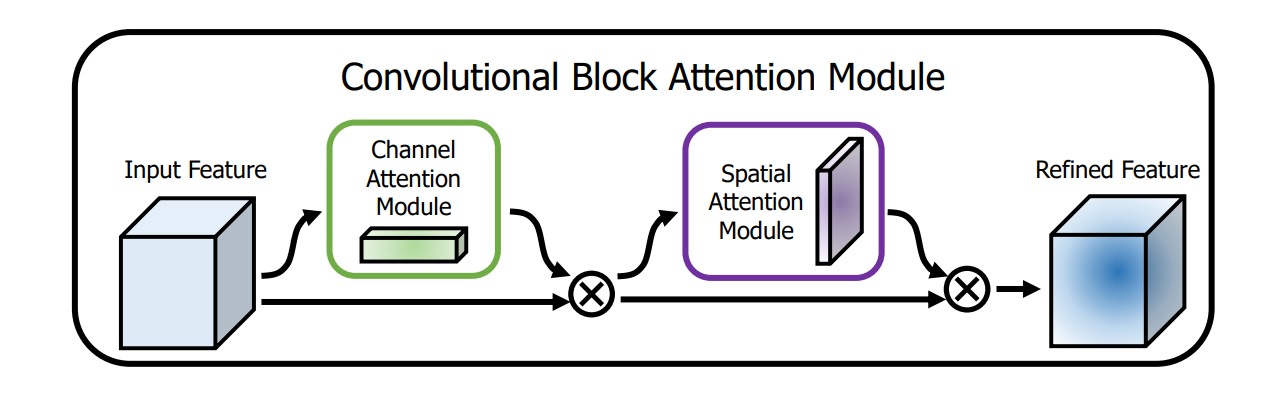

In [ ]:
def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape

    ## Shared layers
    l1 = Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = Dense(channel, use_bias=False)

    ## Global Average Pooling
    x1 = GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)

    ## Global Max Pooling
    x2 = GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)

    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = Activation("sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)

    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)

    ## Concatenat both the features
    feats = Concatenate()([x1, x2])
    ## Conv layer
    feats = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def CBAM(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x


# inputs = Input(shape=(128, 128, 32))
# y = cbam(inputs)
# print(y.shape)

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [ ]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [ ]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

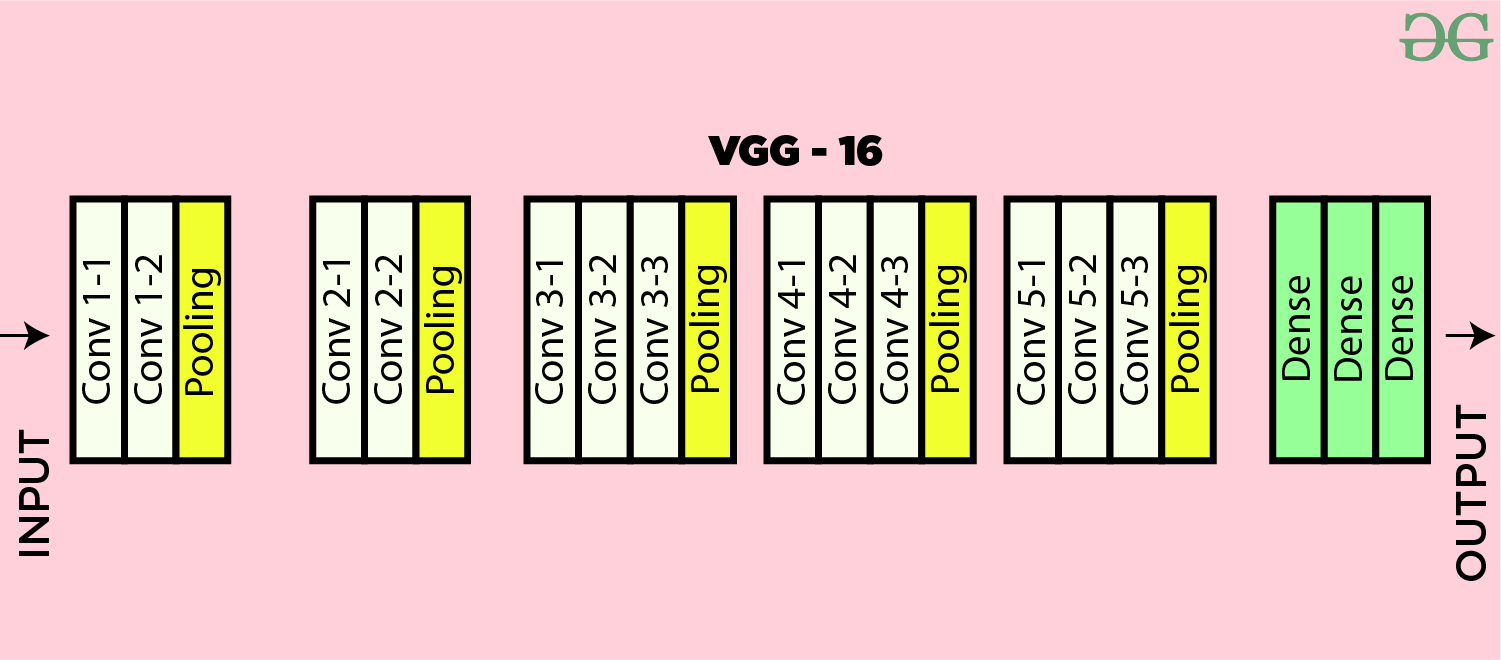

In [ ]:
# input_shape = (512,512,3)
# inputs = Input(input_shape)

# vgg_model = VGG16(include_top=False, weights="imagenet",input_tensor=inputs)
# vgg_model.summary()

# # Encoder
# s1 = vgg_model.layers[0].output                  ## (512 x 512)
# #s1 = vgg_model.get_layer("block2_conv2").output    ## (512 x 512)
# s2 = vgg_model.get_layer("block2_conv2").output    ## (256 x 256)
# s3 = vgg_model.get_layer("block3_conv3").output    ## (128 x 128)
# s4 = vgg_model.get_layer("block4_conv3").output    ## (64 x 64)

# b1 = vgg_model.get_layer("block5_conv3").output    ## (32 x 32)

# # Decoder
# d1 = decoder_block(b1, s4, 512)                    ## (64 x 64)
# d2 = decoder_block(d1, s3, 256)                    ## (128 x 128)
# d3 = decoder_block(d2, s2, 128)                    ## (256 x 256)
# d4 = decoder_block(d3, s1, 64)                     ## (512 x 512)

# # Output
# outputs = Conv2D(3, 1, padding="same", activation="sigmoid")(d4)

# model = Model(inputs, outputs, name="VGG_Model_LowLight_Enhancement")
# model.summary()

In [ ]:
# layer = keras.layers.Dense(3)
# layer.build((None, 4))  # Create the weights
# layer.trainable = False  # Freeze the layer

# print("weights:", len(layer.weights))
# print("trainable_weights:", len(layer.trainable_weights))
# print("non_trainable_weights:", len(layer.non_trainable_weights))

In [ ]:
def build_model(input_shape):
    input_shape = (512,512,3)
    inputs = Input(input_shape)

    vgg_model = VGG16(include_top=False, weights="imagenet",input_tensor=inputs)
    vgg_model.trainable = False
    # vgg_model.summary()

    # Encoder
    s1 = vgg_model.layers[0].output                                             ## (512 x 512)
    s2 = vgg_model.get_layer("block2_conv2").output                             ## (256 x 256)
    s3 = vgg_model.get_layer("block3_conv3").output                             ## (128 x 128)
    s4 = vgg_model.get_layer("block4_conv3").output                             ## (64 x 64)

    b1 = vgg_model.get_layer("block5_conv3").output                             ## (32 x 32)

    # Attention 
    s1 = CBAM(s1)
    s2 = CBAM(s2)
    s3 = CBAM(s3)
    s4 = CBAM(s4)

    # Decoder
    d1 = decoder_block(b1, s4, 512)                                             ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                                             ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                                             ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                                              ## (512 x 512)

    # Output
    outputs = Conv2D(3, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG_Model_LowLight_Enhancement")
    return model

In [ ]:
input_shape = (512, 512, 3)
model = build_model(input_shape)
model.summary()

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model_v2.png",
    show_shapes=True,
    show_layer_activations=True,
)

In [ ]:
print("trainable_weights:", len(model.trainable_weights))
print("non_trainable_weights:", len(model.non_trainable_weights))

## **Setup Losses and Optimizer**

In [ ]:
#optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=0.0001,weight_decay=0.004)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
MSEloss = tf.keras.losses.MeanSquaredError()

In [ ]:
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))

def psnr_loss_fn(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)

def ssim_loss_fn(y_true,y_pred):
    return tf.image.ssim(y_true,y_pred,1.0)


def compute_total_loss(y_true, y_pred):
  ssim =  ssim_loss_fn(y_true,y_pred)
  psnr = psnr_loss_fn(y_true, y_pred)

  #total_loss = 10*ssim + psnr
  total_loss = psnr
  return total_loss


*   callbacks to save best model

*   And Infer the Model while trainning

*   Tensorboard Callback

In [ ]:
from keras.callbacks import ModelCheckpoint

# tensorboard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

# save_best_model_callback
from datetime import datetime
model_save_folder = datetime.now().strftime("%Y%m%d_%H%M%S")
model_save_dir = f'models/{model_save_folder}'
#model_save_dir = f'models'

if not os.path.exists(model_save_dir):
  print("FOLDER CREATED")
  os.makedirs(model_save_dir)

save_best_model_checkpoint = ModelCheckpoint(model_save_dir+'/model-{epoch:03d}.hdf5',monitor='val_loss',save_best_only=True,mode='auto')

In [ ]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
def preprocess_image(img_path):
  img = load_image(img_path)
  img = tf.image.resize(img, (IMAGE_WIDTH,IMAGE_HEIGHT))
  img = img/255;
  return img

In [ ]:
test_low_path = r'/content/drive/MyDrive/FYP/Datastets/Lol_Dataset/LOLdataset_All/eval15/low'
test_high_path = r'/content/drive/MyDrive/FYP/Datastets/Lol_Dataset/LOLdataset_All/eval15/high'

In [ ]:
def find_target_img_path(test_img_file):
  test_img_filename = os.path.basename(test_img_file)
  high_img_path = os.path.join(test_high_path,test_img_filename)
  return high_img_path

In [ ]:
def infer(n_images=2):
  test_low_images = os.listdir(test_low_path)

  for i,image_name in enumerate(test_low_images):
    if i == n_images:
      break
    image_path = os.path.join(test_low_path,image_name)
    print(f'{i+1}/{n_images} : {image_path}')
    low_img = preprocess_image(image_path)
    prediction = model.predict(np.expand_dims(low_img,axis=0),verbose=0)

    high_img_path = find_target_img_path(image_path)
    high_img = preprocess_image(high_img_path)

    fig, ax = plt.subplots(ncols=3, figsize=(15,10));
    ax[0].imshow(low_img);
    ax[1].imshow(prediction[0]);
    ax[2].imshow(high_img);
    ax[0].axis('off');
    ax[1].axis('off');
    ax[2].axis('off');
    ax[0].set_title("Low Image")
    ax[1].set_title("Predicted Image")
    ax[2].set_title("High Image")
    plt.show()

In [ ]:
from tensorflow.keras import callbacks
class PredictionCallback(callbacks.Callback):
    def __init__(self, log_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        #self.image_files = image_files
        self.log_interval = log_interval
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.log_interval == 0: 
          infer(n_images=2)
          

In [ ]:
#model.compile(optimizer,loss, metrics = [charbonnier_loss,psnr_loss_fn,ssim_loss_fn])
model.compile(optimizer,charbonnier_loss, metrics = [MSEloss,psnr_loss_fn,ssim_loss_fn])

## **Sense the predictions**

In [ ]:
X, y = train.as_numpy_iterator().next()
X.shape

In [ ]:
pred = model.predict(X)
plt.imshow(pred[0]);

In [ ]:
print(pred.shape)

## **Load Model**

In [ ]:
# from keras.models import load_model
# model_path = r'/content/drive/MyDrive/FYP2/Test_Models/VGG_LowLight_v1/Test_VGG_LowLight_charbonnier_loss.h5'
# model = load_model(model_path,custom_objects={'charbonnier_loss': charbonnier_loss,
#                                               'psnr_loss_fn':psnr_loss_fn,
#                                               'ssim_loss_fn':ssim_loss_fn})

# compile = False

##3- **Train the Model**

In [ ]:
LOG_INTERVALS = 4
EPOCHS = 100

In [ ]:
# Train for 10 epochs

hist = model.fit(train, epochs=EPOCHS, validation_data = val, callbacks=[tensorboard_callback,save_best_model_checkpoint,
                                                                        PredictionCallback(log_interval = LOG_INTERVALS)])


In [ ]:
model.save("VGGv2.h5")

## **Performace Check**

In [ ]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir './logs'

## **Make Predictions on Test**

In [ ]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()

In [ ]:
print(test_sample[0].shape)

In [ ]:
yhat = model.predict(test_sample[0])

## 4-**Inferencing**

In [ ]:
low_1 = test_sample[0][0]
low_2 = test_sample[0][1]

pred_1 = yhat[0]
pred_2 = yhat[1]

high_1 = test_sample[1][0]
high_2 = test_sample[1][1]

fig, ax = plt.subplots(ncols=3, figsize=(15,10));
ax[0].imshow(low_1);
ax[1].imshow(pred_1);
ax[2].imshow(high_1);
plt.axis('off');

fig, ax = plt.subplots(ncols=3, figsize=(15,10));
ax[0].imshow(low_2);
ax[1].imshow(pred_2);
ax[2].imshow(high_2);
plt.axis('off');

## **Inferencing**

In [ ]:
IMAGE_WIDTH,IMAGE_HEIGHT = 512,512

In [ ]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
def preprocess_image(img_path):
  img = load_image(img_path)
  img = tf.image.resize(img, (IMAGE_WIDTH,IMAGE_HEIGHT))
  img = img/255;
  return img

In [ ]:
test_lowimg_path = r'/content/drive/MyDrive/FYP/Datastets/Lol_Dataset/LOLdataset_All/eval15/low/1.png'
test_highimg_path = r'/content/drive/MyDrive/FYP/Datastets/Lol_Dataset/LOLdataset_All/eval15/high/1.png'

In [ ]:
LowImg = preprocess_image(test_lowimg_path)
HighImg = preprocess_image(test_highimg_path)

In [ ]:
test_prediction = model.predict(np.expand_dims(LowImg,axis=0))

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(15,10));
ax[0].imshow(LowImg);
ax[1].imshow(test_prediction[0]);
ax[2].imshow(HighImg);

In [ ]:
test_low_path = r'/content/drive/MyDrive/FYP/Datastets/Lol_Dataset/LOLdataset_All/eval15/low'
test_high_path = r'/content/drive/MyDrive/FYP/Datastets/Lol_Dataset/LOLdataset_All/eval15/high'

In [ ]:
def find_target_img_path(test_img_file):
  test_img_filename = os.path.basename(test_img_file)
  high_img_path = os.path.join(test_high_path,test_img_filename)
  return high_img_path

In [ ]:
# saving
save_folder_name = 'VGG_LowLight_Results_char_loss_v3_e100'
save_folder_path = os.path.join(HOME,save_folder_name)
if not os.path.exists(save_folder_path):
  print("DIRECTORY CREATED")
  os.makedirs(save_folder_path)

In [ ]:
test_low_images = os.listdir(test_low_path)

#n_images = 2
n_images = len(test_low_images)

for i,image_name in enumerate(test_low_images):
  if i==n_images:
    break
  image_path = os.path.join(test_low_path,image_name)
  print(f'{i+1}/{n_images} : {image_path}')
  low_img = preprocess_image(image_path)
  prediction = model.predict(np.expand_dims(low_img,axis=0),verbose=0)

  high_img_path = find_target_img_path(image_path)
  high_img = preprocess_image(high_img_path)

  fig, ax = plt.subplots(ncols=3, figsize=(15,10));
  ax[0].imshow(low_img);
  ax[1].imshow(prediction[0]);
  ax[2].imshow(high_img);
  ax[0].axis('off');
  ax[1].axis('off');
  ax[2].axis('off');
  ax[0].set_title("Low Image")
  ax[1].set_title("Predicted Image")
  ax[2].set_title("High Image")
  plt.show()

  ### save
  save_name = f'VGG_{image_name.split(".")[0]}.png'
  save_path = os.path.join(save_folder_path,save_name)
  fig.savefig(save_path,bbox_inches='tight',dpi=300);